# qPCA clean
Add notebook description here.

Library imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.linalg import expm
from collections import defaultdict
from IPython.display import display
import warnings

from qiskit_aer import *
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, PhaseEstimation
from qiskit.circuit.library.data_preparation import StatePreparation

## Functions
The following functions are defined in this notebook:
- `pad_matrix(matr)`: Checks matrix dimensions and pads with zeros to reach power of 2.
- `input_state_preparation(matr, verbose)`: Prepares a quantum circuit from given input matrix.
- `build_PE_circuit(qc_init, U, resolution, verbose)`: Constructs the phase estimation circuit.
- `run_PE_circuit(pe_circuit, simulator, n_shots, plot_results)`: Runs the PE circuit and returns measurement counts.
- `complete_counts(counts, n_qubits)`: Adds zero-count states to count results dict.
- `probability_estimation(pe_counts, n_qubits_register, n_shots)`: Estimates probabilities from PE count results.
- `sign_estimation(pe_circuit, init_circuit, probabilities, simulator, n_shots, verbose)`: Creates and runs sign estimation circuit, returns sign dict.
- `eigen_construction(probabilities, sign_dict, resolution, n_qubits, peak_threshold, verbose)`: Constructs eigenvalues and eigenvectors from measurement outcomes.
- `run_qPCA(input_matr, resolution, simulator, n_shots, verbose)`: Run full qPCA for input matrix, return eigenvalues and vectors.

### Data Loading

In [2]:
def pad_matrix(input_matr):
    """
    Checks that the given input matrix is a 2D square matrix, and pads with zeros if
    the dimensions are not a power of 2.

    Args:
    input_matr(np.ndarray): 2D square NumPy array to be padded if necessary.

    Returns:
    tuple(np.ndarray, int): Tuple of Zero-padded square matrix with dimensions being
                            the next power of 2, and power of 2 it was padded to.

    Raises:
    ValueError: If the input is not a 2D matrix or if it is not square.

    """

    # check if matrix is 2D
    if input_matr.ndim !=2:
        raise ValueError(f"Input matrix must be 2D, but is {input_matr.ndim}D")
        
    dimA, dimB = input_matr.shape
    # check if matrix is square matrix
    if dimA != dimB:
        raise ValueError(f"Input matrix must be square, but has shape ({dimA}, {dimB})")
        
    # check if the matrix dimension is a power of 2
    # If not, pad with 0
    if not ((dimA & (dimA-1) == 0) and dimA != 0):
        if dimA == 0:
            n = 0
            new_dim = 1
        else:
            n = int(np.ceil(np.log2(dimA)))
            new_dim = 2**n

        padded_matr = np.zeros((new_dim, new_dim))
        padded_matr[:dimA, :dimB] = input_matr
        return padded_matr, n
        
    else:
        return input_matr, int(np.ceil(np.log2(dimA)))

def input_state_preparation(matr, verbose=False):
    """
    Normalizes input matrix and prepares a quantum circuit with the corresponding initial quantum state.

    Args:
        matr (np.ndarray): Input (covariance) matrix .
        verbose (bool, optional): Whether to print debug information and circuit diagram. Default: False.

    Returns:
        tuple: QuantumCircuit and matrix normalization factor.
    """
    
    # normalize it with the trace
    norm_factor = np.trace(matr) 
    matr_normalized = matr / norm_factor

    # check dims and pad with 0 if necessary
    padded_matr, n = pad_matrix(matr_normalized)
    n_qubits = 2*n

    if verbose: 
        print(f'Input Matrix:\n {matr.round(2)}\n')
        print(f'Normalization factor:\n {norm_factor.round(2)}\n')
        print(f'Padded Normalized Matrix:\n {padded_matr.round(2)}\n')
        print(f'# qubits:\n {n_qubits}\n')
    
    # get amplitudes & normalize
    input_ampl = padded_matr.flatten()
    input_ampl /= np.linalg.norm(input_ampl)
    
    # Build the circuit
    qc = QuantumCircuit(n_qubits, name="Init")
    # prepare state
    init = StatePreparation(input_ampl)
    qc.append(init, qc.qubits)

    if verbose:
        print("Initial state circuit:")
        display(qc.draw('mpl'))

    return qc, padded_matr, norm_factor

### Phase estimation

In [3]:
def build_PE_circuit(qc_init, U, resolution=4, verbose=False):
    """
    Constructs the phase estimation (PE) circuit with the given initial state and unitary operator.

    Args:
        qc_init (QuantumCircuit): Quantum circuit with the state preparation.
        U (QuantumCircuit or Gate): Unitary operator to be estimated.
        resolution (int, optional): Number of evaluation qubits. Default: 4.
        verbose (bool, optional): Whether to print debug information and circuit diagram. Default: False.

    Returns:
        QuantumCircuit: Phase estimation circuit (with measurements).
    """
    
    # prepare qiskit phase estimation
    pe = PhaseEstimation(num_evaluation_qubits=resolution, unitary=U, name="PE")
    # prepare counting register
    n_qubits_register = resolution + qc_init.num_qubits
    pe_register = QuantumRegister(n_qubits_register, "register")
    # initialize circuit
    pe_circuit = QuantumCircuit(pe_register)
    pe_circuit.append(qc_init, pe_register[resolution:]) # why? don't fully understand that bit
    pe_circuit.append(pe.to_gate(), pe_register[:pe.num_qubits])
    pe_circuit.measure_all()

    if verbose:
        print(f'Resolution: {resolution}')
        print(f'# qubits for PE: {n_qubits_register}')

        # draw to check
        print("Phase Estimation circuit:")
        display(pe_circuit.decompose(reps=1).draw('mpl'))

    return pe_circuit    

def run_PE_circuit(pe_circuit, simulator=AerSimulator(), n_shots=50000, plot_results=False):
    """
    Execute the (PE) QuantumCircuit with the given simulator and return measurement counts.

    Args:
        pe_circuit (QuantumCircuit): (PE) circuit to execute.
        simulator (Backend): Simulator backend to use.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        plot_results (bool, optional): Whether to plot a measurement histogram. Default: False.

    Returns:
        dict: Count dictionary with the measurement results.
    """
    
    # transpile the circuit
    pe_transpiled = transpile(pe_circuit, simulator)
    # run circuit
    pe_result = simulator.run(pe_transpiled, shots=n_shots).result()
    # get counts
    pe_counts = pe_result.get_counts()

    # plotting the counts if desired
    if plot_results:
        print("PE result counts:")
        plot = plot_histogram(pe_counts, figsize=(25, 5))
        display(plot)
        
    return pe_counts

### Quantum Tomography

In [4]:
# counts dict by default only contains states that were measured at least once
# so here's quick helper function to get zero count states as well
def complete_counts(counts, n_qubits):
    """
    Add the zero-count states to a qiskit count results dict.

    Args:
        counts (dict): Dictionary of states and measured counts.
        n_qubits (int): Number of measured qubits.

    Returns:
        dict: Dict containing all possible states and counts, incl. zeros.
    """
    keys = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    return {k: counts.get(k, 0) for k in keys}

# TODO: possibly inclcude this in the run_PE_circuit() function instead
def probability_estimation(pe_counts, n_qubits_register, n_shots):
    """
    Compute probability estimates from phase estimation measurement counts.

    Args:
        pe_counts (dict): Measurement counts  from the PE circuit.
        n_qubits_register (int): Number of qubits in the PE cicruit.
        n_shots (int): Number of measurement shots used.

    Returns:
        dict: Dictionary of estimated probabilities for each state.
    """
    # get dictionary with added zero count states 
    pe_counts_tot = complete_counts(pe_counts, n_qubits_register)
    # estimate probs from counts
    probabilities = {state: count / n_shots for state, count in pe_counts_tot.items()}
    return probabilities

def sign_estimation(pe_circuit, init_circuit, probabilities, simulator=AerSimulator(), n_shots=50000, verbose=False):
    """
    Estimates the signs (+1 or -1) of the amplitude coefficients. Constructs and runs a sign estimation circuit from the PE
    and state preparation circuits.

    Parameters:
        pe_circuit (QuantumCircuit): Phase estimation circuit.
        init_circuit (QuantumCircuit): Input state preparation circuit.
        probabilities (dict): Dict of estimated probabilities for each state.
        simulator (Backend, optional): Simulator backend to use for running the circuit. Default: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        verbose (bool, optional): Whether to print debug information, plot circuit diagram and measurement histogram. Default: False.

    Returns:
        dict: Dictionary mapping states to signs (+1 or -1).
    """
    # adjust PE circuit for sign estimation
    pe_circuit.remove_final_measurements() # remove measurements
    
    # prepare unitaries
    U_p = StatePreparation(np.sqrt(list(probabilities.values())),label='U_p').control()
    
    # for U_x, we can't use to_gate bc of StatePreparation
    # so we seperate these parts
    # let's hope this works
    del pe_circuit.data[0] # this is wonky but ok
    # to check:
    if verbose:
        print("PE circuit data :")
        print(pe_circuit.data)
        
    # TODO: give the init to the funciton or figure out how to extract!!!!!!   
    U_x_init = init_circuit.control()
    U_x = pe_circuit.to_gate(label='U_x').control()

    n_qubits_pe = pe_circuit.num_qubits
    resolution = n_qubits_pe-init_circuit.num_qubits

    # prepare the sign estimation circuit
    target_register = QuantumRegister(n_qubits_pe, name='Target')
    control_register = QuantumRegister(1, name='Control')
    se_circuit = QuantumCircuit(target_register, control_register, name='SE')
    # add gates
    se_circuit.h(control_register)
    se_circuit.x(control_register)
    se_circuit.append(U_x_init, control_register[:]+target_register[resolution:n_qubits_pe])
    se_circuit.append(U_x, control_register[:]+target_register[:])
    se_circuit.x(control_register)
    se_circuit.append(U_p, control_register[:]+target_register[:])
    se_circuit.h(control_register)
    se_circuit.measure_all()

    if verbose:
        print("Sign estimation circuit:")
        # draw se circuit
        display(se_circuit.draw('mpl'))

    # Run the circuit using Aer simulator
    se_transpiled = transpile(se_circuit, simulator)
    
    # run with N shots
    se_result = simulator.run(se_transpiled, shots=n_shots).result()
    se_counts = se_result.get_counts()

    if verbose: #TODO: or seperate flag for plotting??
        print("SE result counts:")
        plot = plot_histogram(se_counts, figsize=(25, 5))
        display(plot)

    # filter for counts with Control qubit equal 0
    se_counts_filtered = {state[1:]: counts for state, counts in se_counts.items() if state[0]=='0'}
    # pad with zeros?
    # not sure if necessary or correct
    se_counts_filtered = complete_counts(se_counts_filtered, se_circuit.num_qubits-1)
    # compare to find signs:
    sign_dict = {}
    for state, counts in se_counts_filtered.items():
        if counts > 0.4*n_shots*probabilities[state]:
            sign_dict[state] = 1
        else:
            sign_dict[state] = -1
            
    return sign_dict    

### Eigenvalue and -vector reconstruction:

In [5]:
def eigen_construction(probabilities, sign_dict, resolution, n_qubits, peak_threshold=0.001, verbose=False):
    """
    Reconstructs eigenvalue-eigenvector pairs from the phase estimation results.

    Args:
        probabilities (dict): Dict of estimated probabilities for each state.
        sign_dict (dict): Dict mapping states to their estimated signs (+1 or -1).
        resolution (int): Number of evaluation qubits used in the PE circuit.
        n_qubits (int): Number of qubits used to encode the input matrix.
        peak_threshold (float, optional): Minimum prominence of a peak in the eigenvalue 
                                          histogram to consider it a valid eigenvalue.
                                          Default: 0.001.
        verbose (bool, optional): Whether to print debug information. Default: False.

    Returns:
        Tuple of lists: List of eigenvalues and list of corresponding eigenvectors.
    """
    # initialise lambdas dict
    lambdas_dict = defaultdict(float) # to avoid missing key checks and init with 0.0
    for state, prob in probabilities.items():
        lam = state[-resolution:]
        lambdas_dict[lam] += prob
    
    # Convert to sorted list
    lambda_keys = sorted(lambdas_dict, key=lambda x: int(x[::-1], 2))
    lambda_probs = np.array([lambdas_dict[k] for k in lambda_keys])
    
    # Find peaks
    peaks_idx, _ = find_peaks(lambda_probs, threshold=peak_threshold) # TODO: investigate threshold more?
    peak_lambda_keys = [lambda_keys[i] for i in peaks_idx]

    if verbose: 
        print("found peaks: ", peaks_idx, peak_lambda_keys) 
    
    eigvals = []
    eigvecs = []
    for lam in peak_lambda_keys:
        # compute and save eigenvalue
        eigval = int(lam[::-1], 2) / 2**resolution
        eigvals.append(eigval)

        if verbose: 
            print(f"\nEigenvalue: {eigval}")
            
        # collect amplitudes from all relevant states
        amps = [
            (state[:-resolution], sign_dict[state] * np.sqrt(probabilities[state]))
            for state in probabilities if state.endswith(lam)
        ]
        # construct amplitude vector sorted by basis state
        vec = np.array([amp for _, amp in sorted(amps, key=lambda x: x[0])])

        vec /= np.linalg.norm(vec)
    
        # find dominant eigvec
        chunks = vec.reshape(-1, n_qubits) # reshape into eigvec-sized chunks
        max_chunk = np.max(np.abs(chunks), axis=1) # get each chunk's max value
        idx_max = np.argmax(max_chunk) # get index of chunk with max value
        best_chunk = chunks[idx_max] # select chunk with largest value
    
        # this is how they normalize
        eigvec = best_chunk / np.sqrt(np.max(np.abs(best_chunk)))
            
        # they normalized in a slightly different way that confused me greatly
        # I hope this works too?
        #eigvec = best_chunk / np.linalg.norm(best_chunk) # normalize 

        if verbose:
            print("Eigenvector chunks:", chunks)
            print("Max amplitudes: ", max_chunk)
            print("Dominant chunk: ", best_chunk)
        
        eigvecs.append(eigvec)

    return eigvals, eigvecs

### Full qPCA

In [6]:
def run_qPCA(input_matr, resolution: int = 5, simulator=AerSimulator(), n_shots=50000, verbose: bool = False):
    """
    Performs full Quantum Principal Component Analysis (qPCA) on a Hermitian input matrix, returns eigenvalues
    and eigenvectors.

    Parameters:
        input_matr (np.ndarray): Input matrix to perform qPCA on.
        resolution (int, optional): Number of evaluation qubits to use in phase estimation. Default: 5.
        simulator (Backend, optional): Qiskit simulator backend to use. Defaults: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots for circuit execution. Default: 50000.
        verbose (bool, optional): If True, prints steps, debug info, and intermediate results (such as circuit 
                                diagrams and plots). Default: False.

    Returns:
        tuple of lists: List of eigenvalues and list of corresponding eigenvectors.
    """
    
    # prepare circuit with state preparation according to input matrix
    if verbose: print("\nInput State preparation...")
    qc_init, padded_matr, norm_factor = input_state_preparation(input_matr, verbose=verbose)
    
    # define unitary for phase estimation
    # placeholder until I include the proper unitary creation function
    if verbose: print("\nUnitary gate construction...")
    U = UnitaryGate(expm(1j * padded_matr * 2*np.pi))
    
    # build phase estimation circuit
    if verbose: print("\nBuilding Phase Estimation circuit...")
    pe_circuit = build_PE_circuit(qc_init, U, resolution=resolution, verbose=verbose)
    
    # run the circuit and get the counts
    if verbose: print("\nRunning Phase Estimation...")
    pe_counts = run_PE_circuit(pe_circuit, simulator=simulator, n_shots=n_shots, plot_results=verbose)
    
    # compute probailities from counts
    if verbose: print("\nProbability estimation...")
    probabilities = probability_estimation(pe_counts, pe_circuit.num_qubits, n_shots)
    
    # estimate the signs 
    if verbose: print("\nSign estimation...")
    sign_dict = sign_estimation(pe_circuit, qc_init, probabilities, simulator=simulator, n_shots=n_shots, verbose=verbose)
    
    # construct eigenvectors and eigenvalues from results
    if verbose: print("\nEigenvalue and -vector construction...")
    eigvals, eigvecs = eigen_construction(probabilities, sign_dict, resolution, qc_init.num_qubits, peak_threshold=0.001, verbose=verbose)
    
    # rescale with norm_factor
    eigvals = norm_factor * np.array(eigvals)

    # print to check
    if verbose:
        for val, vec in zip(eigvals, eigvecs):
            print(f'Eigenvalue: {val.round(3)}, eigenvector: {vec.round(3)}')
        print("Done!")
        
    return eigvals, eigvecs

## Main

Testing the implentation with verbose setting:


Input State preparation...
Input Matrix:
 [[1.5 0.5]
 [0.5 1.5]]

Normalization factor:
 3.0

Padded Normalized Matrix:
 [[0.5  0.17]
 [0.17 0.5 ]]

# qubits:
 2

Initial state circuit:


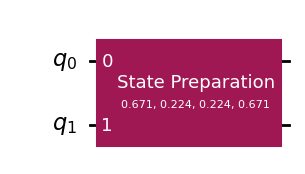


Unitary gate construction...

Building Phase Estimation circuit...
Resolution: 5
# qubits for PE: 7
Phase Estimation circuit:


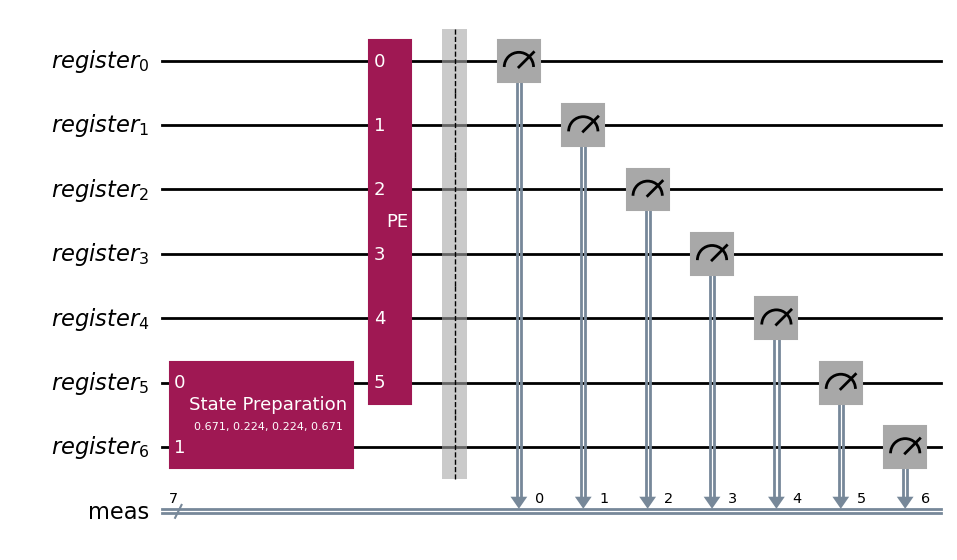


Running Phase Estimation...
PE result counts:


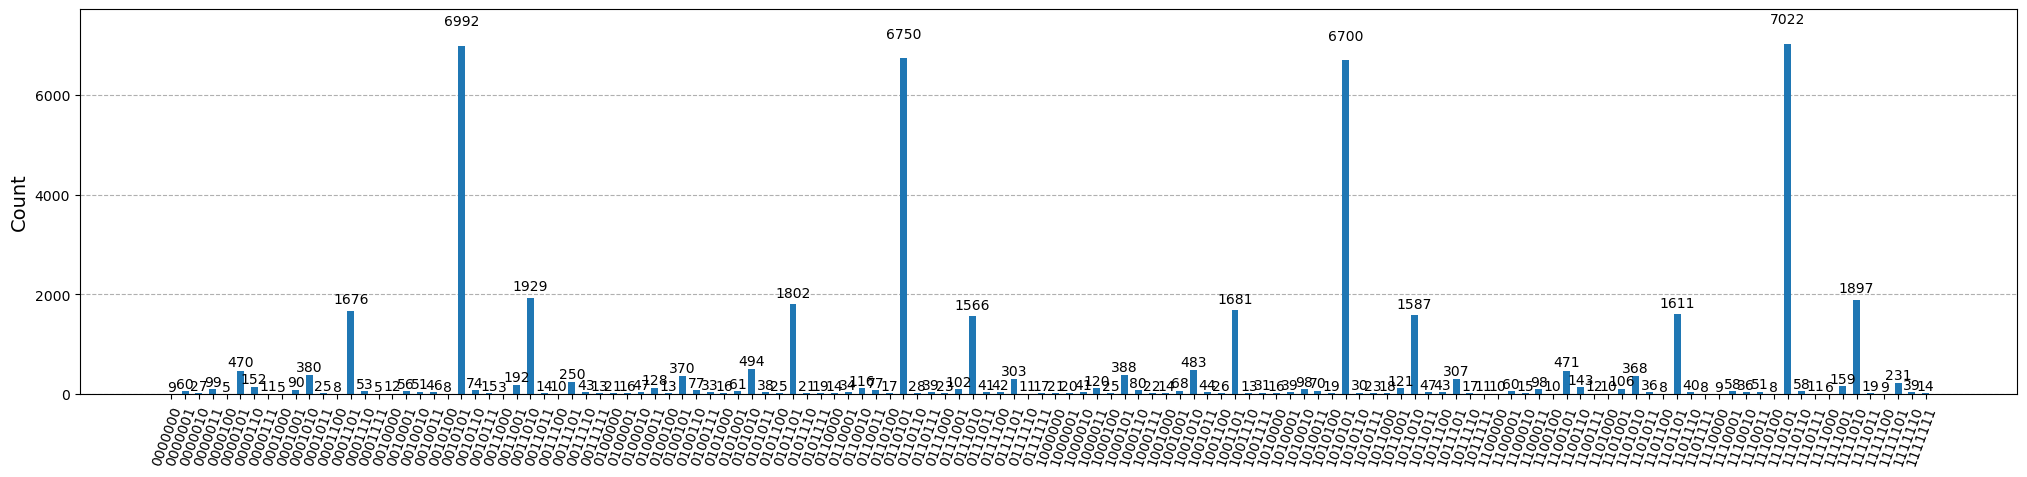


Probability estimation...

Sign estimation...
PE circuit data :
[CircuitInstruction(operation=Instruction(name='PE', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(7, 'register'), 0), Qubit(QuantumRegister(7, 'register'), 1), Qubit(QuantumRegister(7, 'register'), 2), Qubit(QuantumRegister(7, 'register'), 3), Qubit(QuantumRegister(7, 'register'), 4), Qubit(QuantumRegister(7, 'register'), 5)), clbits=())]
Sign estimation circuit:


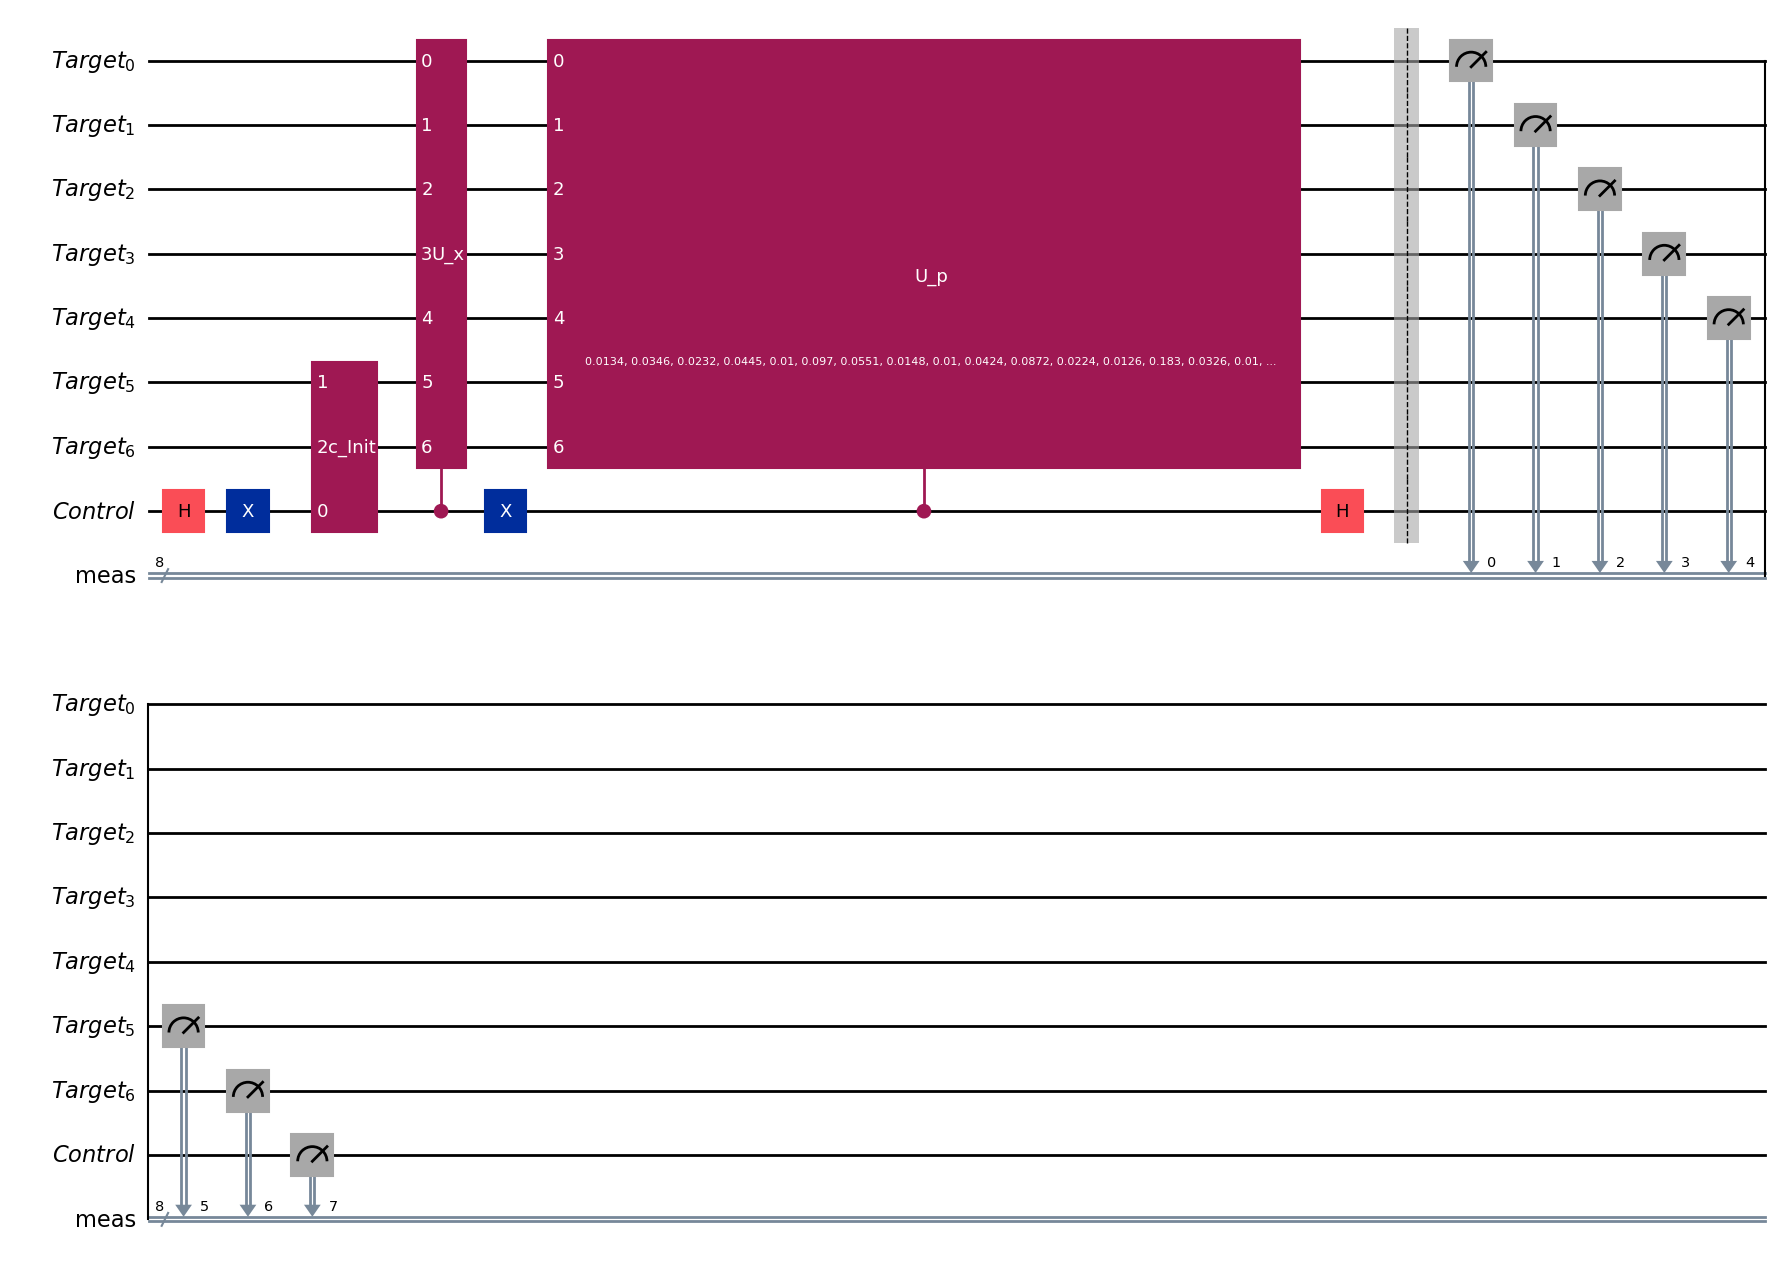

SE result counts:


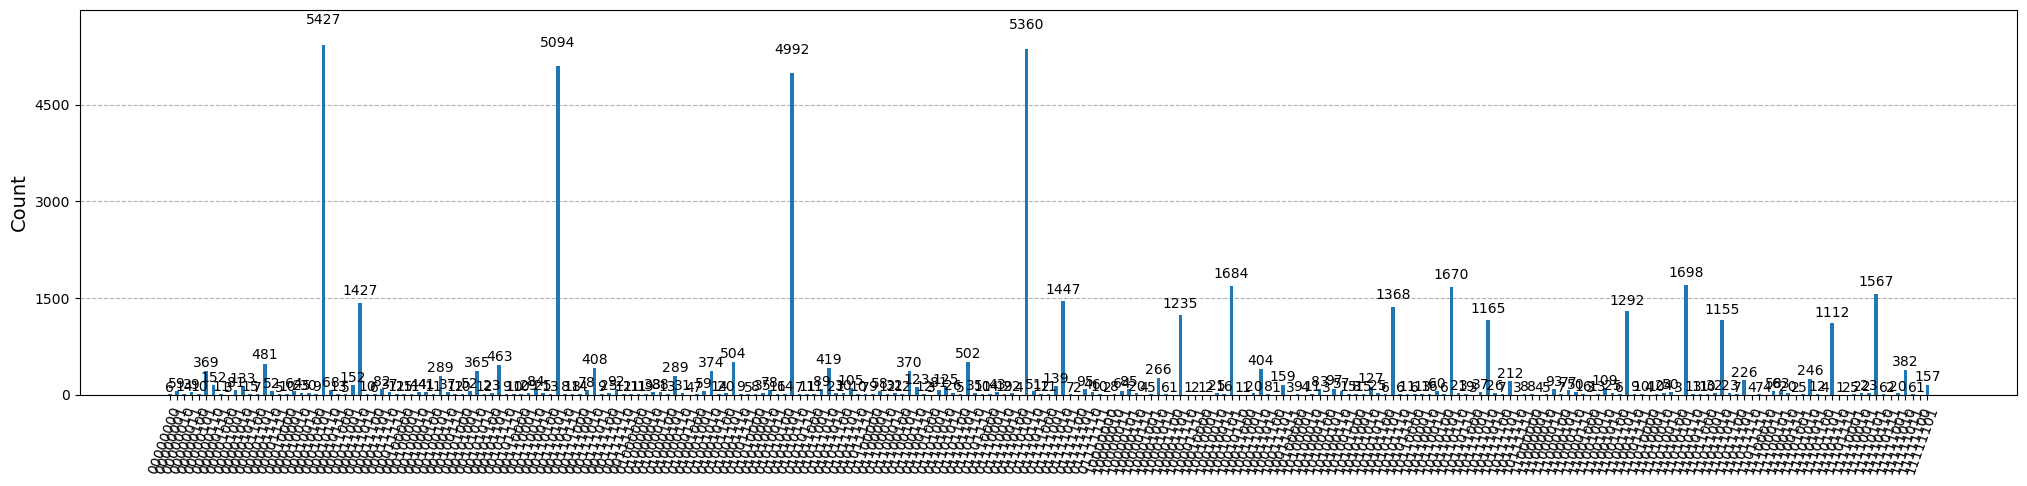


Eigenvalue and -vector construction...
found peaks:  [11 21] ['11010', '10101']

Eigenvalue: 0.34375
Eigenvector chunks: [[ 0.52573818 -0.47369552]
 [-0.47686106  0.52135923]]
Max amplitudes:  [0.52573818 0.52135923]
Dominant chunk:  [ 0.52573818 -0.47369552]

Eigenvalue: 0.65625
Eigenvector chunks: [[0.50456697 0.4957583 ]
 [0.49391874 0.50564826]]
Max amplitudes:  [0.50456697 0.50564826]
Dominant chunk:  [0.49391874 0.50564826]
Eigenvalue: 1.031, eigenvector: [ 0.725 -0.653]
Eigenvalue: 1.969, eigenvector: [0.695 0.711]
Done!


In [7]:
# input matrix for testing
matr = np.array([[1.5, 0.5],[0.5, 1.5]])
eigvals, eigvecs = run_qPCA(matr, verbose=True)

Checking different resolution settings:

In [8]:
# compute theoretical eigenvectors and -values for comparison
eigvals_cl, eigvecs_cl = np.linalg.eig(matr)

# compute eigenvalues and vectors for different resolutions
eigval_diffs, eigvec_diffs, res = [], [], []
for r in range(2, 17):
    print(f'Running resolution r={r}')
    # compute eigvecs/vals via qPCA
    vals, vecs = run_qPCA(matr, resolution=r)
    
    # skip iteration if no eigvals/vecs were found
    if len(vals)==0:
        continue
        
    # compute differences between qPCA and classical result
    for val, vec in zip(vals, vecs):
        res.append(r)
        # find idx of closest classical eigval 
        idx = np.argmin([abs(val - val_cl) for val_cl in eigvals_cl])
        # use that as reference for diff computation
        val_cl = eigvals_cl[idx]
        vec_cl = eigvecs_cl[:, idx]
        # compute differences & append to lists
        eigval_diffs.append(val_cl - val)
        eigvec_diffs.append(np.linalg.norm(vec_cl - vec))

Running resolution r=2
Running resolution r=3
Running resolution r=4
Running resolution r=5
Running resolution r=6
Running resolution r=7
Running resolution r=8
Running resolution r=9
Running resolution r=10
Running resolution r=11
Running resolution r=12
Running resolution r=13
Running resolution r=14
Running resolution r=15
Running resolution r=16


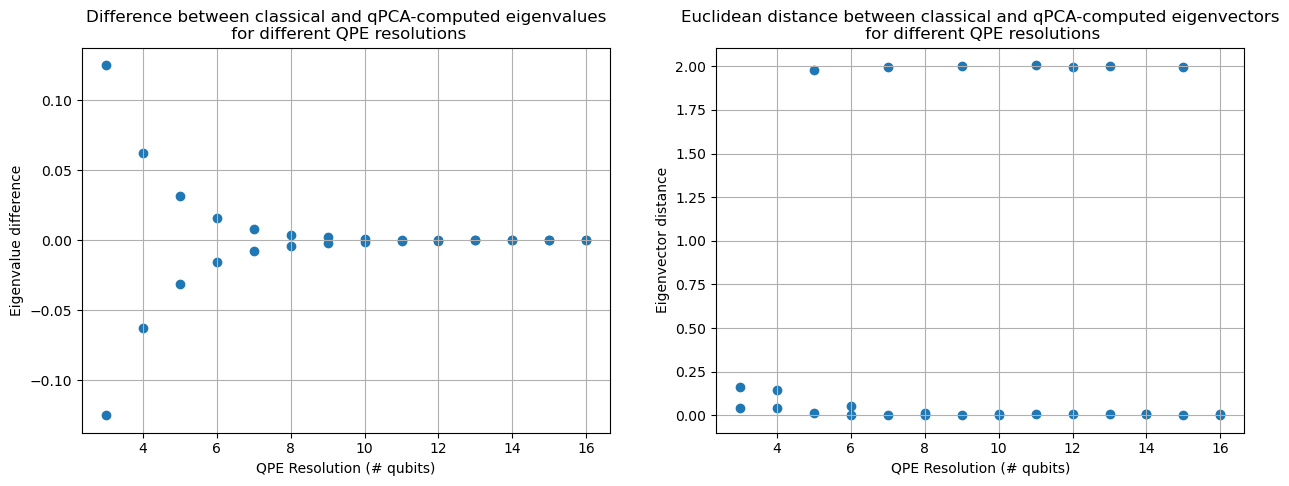

In [9]:
# plot results
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
# eigval distance plot
ax[0].scatter(res, eigval_diffs)
ax[0].set_title("Difference between classical and qPCA-computed eigenvalues\n for different QPE resolutions")
ax[0].set_xlabel("QPE Resolution (# qubits)")
ax[0].set_ylabel("Eigenvalue difference")
ax[0].grid()
# eigvec distance plot
ax[1].scatter(res, eigvec_diffs)
ax[1].set_title("Euclidean distance between classical and qPCA-computed eigenvectors\n for different QPE resolutions")
ax[1].set_xlabel("QPE Resolution (# qubits)")
ax[1].set_ylabel("Eigenvector distance")
ax[1].grid()

plt.show()

Investigate different measurement shots `n_shots` settings:

In [10]:
# compute theoretical eigenvectors and -values for comparison
eigvals_cl, eigvecs_cl = np.linalg.eig(matr)

# n_shot values
n_shot_vals = np.logspace(3, 5, 30, dtype=int)

# compute eigenvalues and vectors for different resolutions
eigval_diffs_n, eigvec_diffs_n, n_shots = [], [], []
for n in n_shot_vals:
    print(f'Running with n={n} shots')
    # compute eigvecs/vals via qPCA
    vals, vecs = run_qPCA(matr, resolution=6, n_shots=n)
    
    # skip iteration if no eigvals/vecs were found
    if len(vals)==0:
        continue
        
    # compute differences between qPCA and classical result
    for val, vec in zip(vals, vecs):
        n_shots.append(n)
        # find idx of closest classical eigval 
        idx = np.argmin([abs(val - val_cl) for val_cl in eigvals_cl])
        # use that as reference for diff computation
        val_cl = eigvals_cl[idx]
        vec_cl = eigvecs_cl[:, idx]
        # compute differences & append to lists
        eigval_diffs_n.append(val_cl - val)
        eigvec_diffs_n.append(np.linalg.norm(vec_cl - vec))

Running with n=1000 shots
Running with n=1172 shots
Running with n=1373 shots
Running with n=1610 shots
Running with n=1887 shots
Running with n=2212 shots
Running with n=2592 shots
Running with n=3039 shots
Running with n=3562 shots
Running with n=4175 shots
Running with n=4893 shots
Running with n=5736 shots
Running with n=6723 shots
Running with n=7880 shots
Running with n=9236 shots
Running with n=10826 shots
Running with n=12689 shots
Running with n=14873 shots
Running with n=17433 shots
Running with n=20433 shots
Running with n=23950 shots
Running with n=28072 shots
Running with n=32903 shots
Running with n=38566 shots
Running with n=45203 shots
Running with n=52983 shots
Running with n=62101 shots
Running with n=72789 shots
Running with n=85316 shots
Running with n=100000 shots


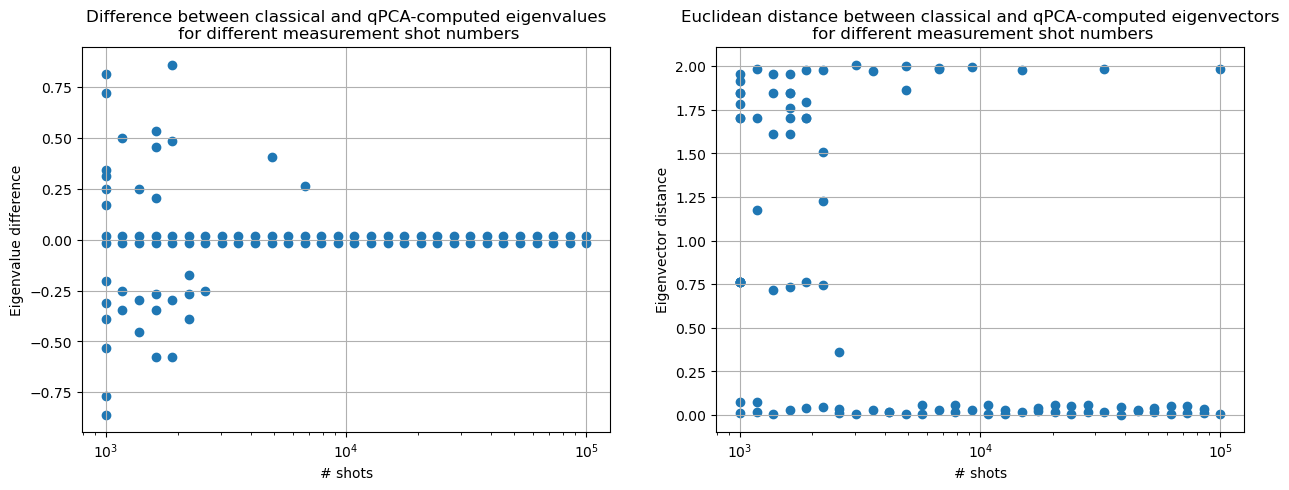

In [11]:
# plot results
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
# eigval distance plot
ax[0].scatter(n_shots, eigval_diffs_n)
ax[0].set_title("Difference between classical and qPCA-computed eigenvalues\n for different measurement shot numbers")
ax[0].set_xlabel("# shots")
ax[0].set_ylabel("Eigenvalue difference")
ax[0].set_xscale("log")
ax[0].grid()
# eigvec distance plot
ax[1].scatter(n_shots, eigvec_diffs_n)
ax[1].set_title("Euclidean distance between classical and qPCA-computed eigenvectors\n for different measurement shot numbers")
ax[1].set_xlabel("# shots")
ax[1].set_ylabel("Eigenvector distance")
ax[1].set_xscale("log")
ax[1].grid()

plt.show()

Hmmmmm...